## Face Detection and Recognition

In 2017, a group of researchers at the University of Oxford’s Visual Geometry Group in the U.K. published a paper entitled [VGGFace2: A dataset for recognising faces across pose and age](https://arxiv.org/abs/1710.08092). After assembling a dataset comprising several million facial images, they trained two variations of `ResNet50` with it and published the results. They also published the weights, which are wrapped in a handy Python library named [keras-vggface](https://pypi.org/project/keras-vggface/). That library includes a class named `VGGFace` that encapsulates `ResNet50` with TensorFlow-compatible weights. Out of the box, `VGGFace` is capable of recognizing the faces of thousands of celebrities ranging from Brie Larson to Jennifer Aniston. But its real value lies in using transfer learning to repurpose it to recognize faces it wasn’t trained to recognize before.

let’s build a notebook that trains a facial-recognition model based on `VGGFace`, uses `MTCNN` to detect faces in photos, and uses the model to identify the faces it detects. Begin by defining helper functions for loading and displaying facial images and declaring a pair of Python lists to hold the images and labels:

In [1]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})
 
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

Next, load the images of me and label them with 0s:

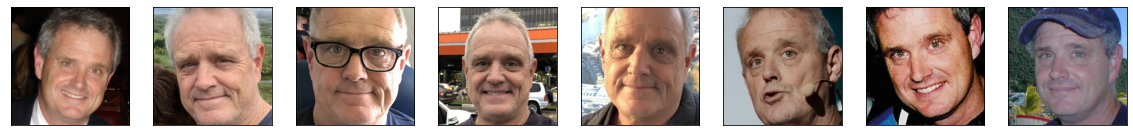

In [2]:
images, labels = load_images_from_path('Faces/Jeff', 0)
show_images(images)
    
x += images
y += labels

Load the images of my wife and label them with 1s:

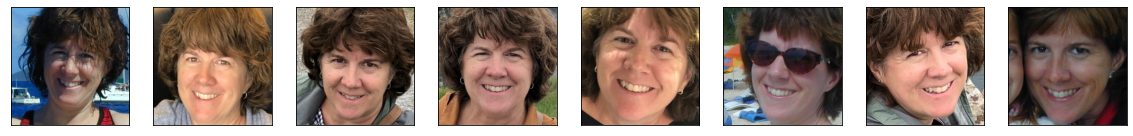

In [3]:
images, labels = load_images_from_path('Faces/Lori', 1)
show_images(images)
    
x += images
y += labels

Load the images of my daughter and label them with 2s:

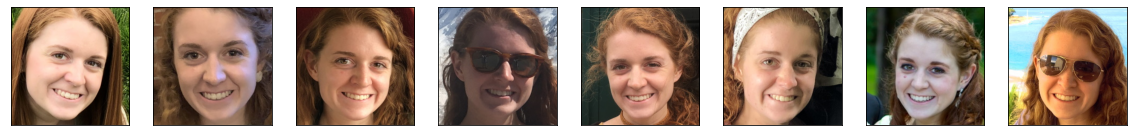

In [4]:
images, labels = load_images_from_path('Faces/Abby', 2)
show_images(images)
    
x += images
y += labels

Finally, preprocess the pixels for `ResNet50` version of `VGGFace` and split the data 50-50 so the network will be trained with four randomly selected images of each person and validated with the same number of images:

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

faces = preprocess_input(np.array(x))
labels = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(faces, labels,
                                                    train_size=0.5, stratify=labels,
                                                    random_state=0)

The data is ready. Now let's put it to work.

## Train a model

The next step is to load the saved `VGGFace` model and freeze the bottleneck layers:

In [6]:
from tensorflow.keras.models import load_model

base_model = load_model('Data/vggface.h5')
base_model.trainable = False

Now, define a network that uses transfer learning with the loaded `VGGFace` model to identify faces. Note the `Resizing` layer to ensure that each image measures exactly 224x224:

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model.

In [8]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=2, epochs=10)

Epoch 1/10
6/6 [==============================] - 4s 260ms/step - loss: 1.0111 - accuracy: 0.8333 - val_loss: 0.9097 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 1s 134ms/step - loss: 0.8563 - accuracy: 1.0000 - val_loss: 0.7717 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 1s 132ms/step - loss: 0.7218 - accuracy: 1.0000 - val_loss: 0.6478 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 1s 128ms/step - loss: 0.6039 - accuracy: 1.0000 - val_loss: 0.5351 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 1s 128ms/step - loss: 0.4933 - accuracy: 1.0000 - val_loss: 0.4327 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 1s 129ms/step - loss: 0.3966 - accuracy: 1.0000 - val_loss: 0.3432 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 131ms/step - loss: 0.3121 - accuracy: 1.0000 - val_loss: 0.2678 - val_accuracy: 1.0000
Epoch 8/10
6/6 [====

Plot the training and validation accuracy.

[]

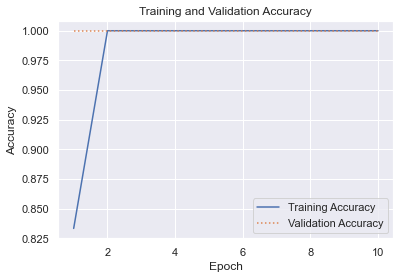

In [9]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to tag faces in images

Now comes the fun part: Using MTCNN to detect the faces in a photo and the trained model to identify those faces. Start by defining a pair of helper function: one that retrieves a face from a specified location in an image (`get_face`), and another that loads a photo and labels the faces in the photo with names and confidence levels (`label_faces`):

In [10]:
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from matplotlib.patches import Rectangle

def get_face(image, face):
    x1, y1, w, h = face['box']
    
    if w > h:
        x1 = x1 + ((w - h) // 2)
        w = h
    elif h > w:
        y1 = y1 + ((h - w) // 2)
        h = w
    
    x2 = x1 + h
    y2 = y1 + w
    
    return image[y1:y2, x1:x2]

def label_faces(path, model, names, face_threshold=0.9, prediction_threshold=0.8, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]

    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    fig, ax = plt.subplots(figsize=size, subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(np_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']
        
        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
            # Optionally draw a box around around the face
            if show_outline:
                rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
                ax.add_patch(rect)
            
            # Label the face
            index = int(np.argmax(predictions))
            text = f'{names[index]} ({confidence:.1%})'
            ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red', ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))    

Now pass the first sample image in the “Samples” folder to `label_faces`:

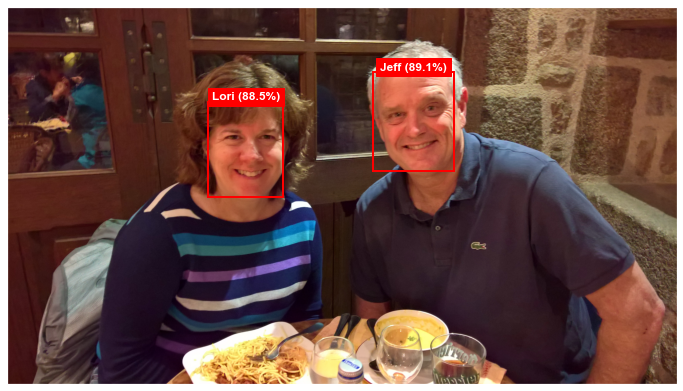

In [11]:
labels = ['Jeff', 'Lori', 'Abby']
label_faces('Faces/Samples/Sample-1.jpg', model, labels)

Try it again, but this time with a different photo:

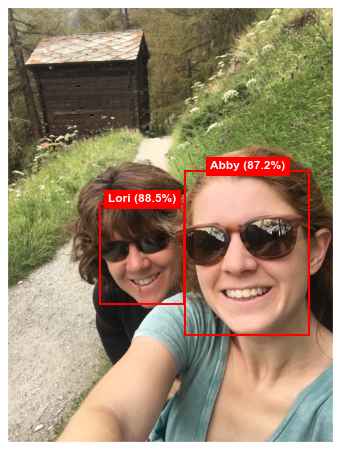

In [12]:
label_faces('Faces/Samples/Sample-2.jpg', model, labels)

Trained with just 12 facial images – four of each person – the model does a credible job of identifying the faces in photos. Of course, you could generate a dataset of your own friends and family members and train the model with the resulting images.

With a highly optimized set of weights, a neural network can do almost anything. Generic weights will suffice when nothing better is available, but given a task-specific set of weights to start with, transfer learning can be pure magic.